In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Get your data

In [103]:
normal = pd.read_csv("ptbdb_normal.csv", header=None)
abnormal = pd.read_csv("ptbdb_abnormal.csv", header=None)

print(normal.shape)
print(abnormal.shape)

(4046, 188)
(10506, 188)


In [104]:
combined = pd.concat( [normal, abnormal], axis=0, ignore_index=True)

combined.shape


(14552, 188)

In [105]:
X = combined.drop(columns=[187])
X = X.values

y = combined[187]
y = y.values

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11641, 187)
(2911, 187)
(11641,)
(2911,)


In [107]:
smote = SMOTE(random_state=42)

X_train, y_train = smote.fit_resample(X_train, y_train)

print(X_train.shape)
print(y_train.shape)

(16858, 187)
(16858,)


In [108]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([16858, 187])
torch.Size([2911, 187])
torch.Size([16858])
torch.Size([2911])


Now, pretty big difference here when it comes t comparing neural netwroks, to convolutional neural networks. 

Neural networks: 
- the input data is typically passed as a 2D tensor with the shape (batch size, features). 
- Each sample is a vector of features, like the 187 features of the data. 
- For instance, X_train_smote is already in the 2d format: (16858, 187), where 16858 is the number of samples, and 187 is the number of features per sample.

Convolutional Neural Networks: 
- input data for a 1d cnn is a 3d tensor with the shape (batch_size, channels, length)
- CNNs work on images (or grids), which have multiple dimensions: the height, width, and channels (Like RGB images have 3 channels: red, green, and blue).
- In the case of the ECG data, we have 187 features (values) per sample.
- We treat these a single sample of 187 features as a 1d sequence of features
- since each signal is a 1d sequence, then we only need one channel (a single feature set)

Explaning 3D Tensor Shape (batch_size, channels, length):
- batch_size is the number of samples we are passing to the model in a single batch. (in this case, we are just sending the whole dataset in one go, no batches).
- channels is the number of channels in the data. Since the data is 1D (ECG signal), it has 1 channel.
- length is simply the length of the 1D signal. In this case, this is the number of features (187).


Therefore, our final shape look like this:
- (batch_size, channels, Length) = (16858, 1, 187)


Note: 
- We reshape X variables go work along the model
- No need to reshape y variables as those are just lables, which are handled by the loss function 

-------------------------------------------------------------------------
For Future reference: 
- 1D CNN: Works with sequences (like time-series data, text). Shape: (batch_size, channels, length).
- 2D CNN: Works with images or spatial data. Shape: (batch_size, channels, height, width).
- 3D CNN: Works with volumetric data or video. Shape: (batch_size, channels, depth, height, width).

Key Differences:
- 1D CNN uses convolution along one axis (usually time or sequence).
- 2D CNN uses convolution over two axes (height and width).
- 3D CNN uses convolution over three axes (depth, height, and width).





In [109]:
X_train = X_train.unsqueeze(1)  #add channel dimension [6400, 1, 187]
X_test = X_test.unsqueeze(1)    #add channel dimension [1600, 1, 187]

print(X_train.shape)
print(X_test.shape)


torch.Size([16858, 1, 187])
torch.Size([2911, 1, 187])


In [110]:
class Binary_CNN_ECG(nn.Module):
    #input_channels: number of input channels. For 1D signals, typically 1.
    #binary classification so out=2

    def __init__(self, input_channels = 1, out = 2, dropout_rate = 0.5):
        super().__init__() 
        
        #convolutional layers
        #signal starts as a tensor (batch size,1,187). input is 1 as the ECG data has one channel (single feature per time point
        #first layer learns 32 different patterns, sliding window of size 3, stride/step of 1
        #padding adds 1 zero on each side of the input to ensure output size remains 187
        self.conv1 = nn.Conv1d(input_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)

        #pooling layer

        #this layer "downsamples" the data, reducing its size while keeping prominent features/patterns
        #pooling window is 2 time points, stride/step is 2 at a time
        #since we picked 2, that measn that our data shrinks by half every layer

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        #finish off with fully connected layers

        #we divie the size of our input by 2 exaclty 3 times, as our pooling function is called 3 times
        #// is the floor operator
        self.fc1 = nn.Linear(32 * (187 // 2 // 2), 64)
        self.fc2 = nn.Linear(64,out)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        #convolutional layers with relu and pooling
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        #flatten the tensor for the fully connected layers, as fully connected layers expect
        #input tensor to be in the form (batch_size, features)
        # so it goes from (batch_size, 32, 46) to (batch_size, 1472)
        #note: start_dim=1 meas we flatten from the first dimension after the batch dimension (0)
        x = torch.flatten(x, start_dim=1)
 
        #fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
      
        return x


In [111]:
#create instance
binary_cnn_model = Binary_CNN_ECG()

#define loss fucntion 
loss_func =  nn.CrossEntropyLoss() #critereon


#define optimizer
optimizer = torch.optim.Adam(binary_cnn_model.parameters(), lr=0.01)

In [112]:
binary_cnn_model

Binary_CNN_ECG(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1472, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [113]:
import time

epochs = 100

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

start_time = time.time()

for i in range(epochs):
    binary_cnn_model.train()

    #for confusion matrix
    train_preds = []
    train_truths = []
    test_preds = []
    test_truths = []
    
    y_pred_train = binary_cnn_model(X_train)
    train_loss = loss_func(y_pred_train, y_train)
    
    #accuracy calculation (I go over this in a cell at the end of this notebook)
    _, train_predicted = torch.max(y_pred_train, 1)
    train_acc = (train_predicted == y_train).sum().item() / y_train.size(0) * 100

    #for graphs & stats
    train_losses.append(train_loss.item())
    train_accuracies.append(train_acc)
    #for confusion matrix
    train_preds.extend(train_predicted.numpy())
    train_truths.extend(y_train.numpy())

    #backward pass and optimization
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    #test
    binary_cnn_model.eval()
    with torch.no_grad():
        y_pred_test = binary_cnn_model(X_test)
        test_loss = loss_func(y_pred_test, y_test)

        _, test_predicted = torch.max(y_pred_test, 1)
        test_acc = (test_predicted == y_test).sum().item() / y_test.size(0) * 100

        #for graphs and stats
        test_losses.append(test_loss.item())
        test_accuracies.append(test_acc)

        #for confusion matrix
        test_preds.extend(test_predicted.numpy())
        test_truths.extend(y_test.numpy())
    

    print(f"Epoch {i+1} / {epochs}")
    print(f"Train Loss: {train_loss.item():.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_acc:.4f}")


current_time = time.time()
total = current_time - start_time
print("")
print(f"this took {total} seconds \n")


Epoch 1 / 100
Train Loss: 0.6932, Train Accuracy: 50.4746
Test Loss: 0.6297, Test Accuracy: 71.3501
Epoch 2 / 100
Train Loss: 0.7127, Train Accuracy: 52.4024
Test Loss: 1.0639, Test Accuracy: 28.6499
Epoch 3 / 100
Train Loss: 0.8319, Train Accuracy: 50.6703
Test Loss: 0.5760, Test Accuracy: 72.4837
Epoch 4 / 100
Train Loss: 0.6592, Train Accuracy: 56.6319
Test Loss: 0.5556, Test Accuracy: 71.5218
Epoch 5 / 100
Train Loss: 0.6637, Train Accuracy: 52.9541
Test Loss: 0.5788, Test Accuracy: 72.9646
Epoch 6 / 100
Train Loss: 0.6310, Train Accuracy: 63.7976
Test Loss: 0.5870, Test Accuracy: 69.8042
Epoch 7 / 100
Train Loss: 0.6142, Train Accuracy: 69.7058
Test Loss: 0.5742, Test Accuracy: 69.0141
Epoch 8 / 100
Train Loss: 0.5963, Train Accuracy: 70.9693
Test Loss: 0.5556, Test Accuracy: 68.9110
Epoch 9 / 100
Train Loss: 0.5821, Train Accuracy: 71.2777
Test Loss: 0.5505, Test Accuracy: 68.8767
Epoch 10 / 100
Train Loss: 0.5707, Train Accuracy: 71.5150
Test Loss: 0.5835, Test Accuracy: 67.3995

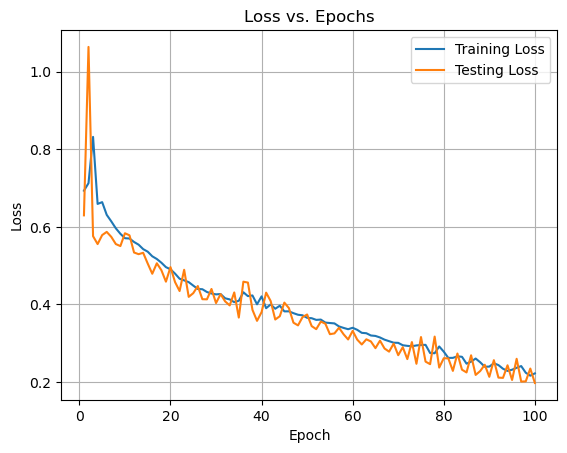

In [114]:
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label="Training Loss")
plt.plot(range(1, epochs+1), test_losses, label="Testing Loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

Training Confusion Matrix:
[[8157  272]
 [1249 7180]]


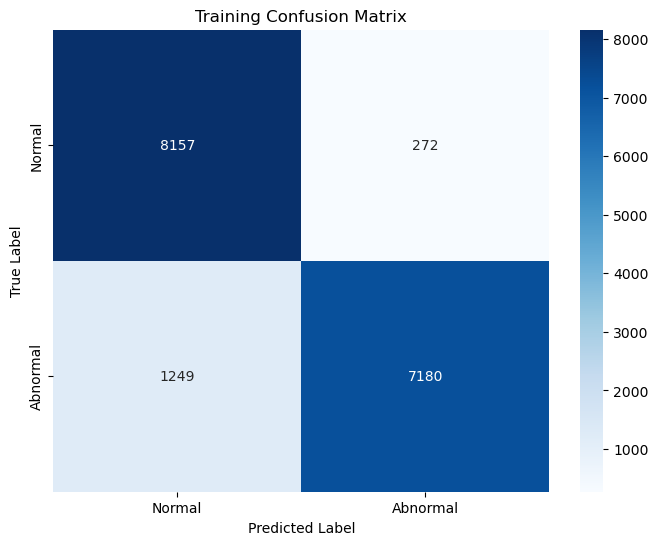

Testing Confusion Matrix:
[[ 736   98]
 [ 137 1940]]


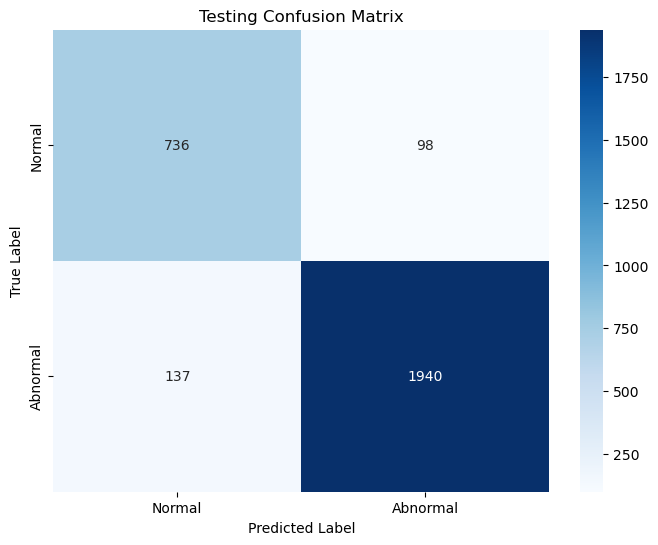

In [115]:
#training confusion matrix
train_cm = confusion_matrix(train_truths, train_preds)
print("Training Confusion Matrix:")
print(train_cm)

plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.title("Training Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#testing confusion matrix
test_cm = confusion_matrix(test_truths, test_preds)
print("Testing Confusion Matrix:")
print(test_cm)

plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.title("Testing Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Grab a sample, run though model, and comapre to see if model gets it right

In [119]:
sample = X_train[269]
truth = y_train[269]

#apply unsqueeze to get it to the proper shape for model
output = binary_cnn_model(sample.unsqueeze(1))
_, pred = torch.max(output,dim=1)
print(pred.item())
print(truth.item())

1
1
